In [75]:
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Union
import sklearn
import math

In [76]:
if not os.path.exists('..\\models'):
    os.makedirs('..\\models')
if not os.path.exists('..\\plots'):
    os.makedirs('..\\plots')

In [93]:
class DLModel:
    """
        Model Class to approximate the Z function as defined in the assignment.
    """

    def __init__(self):
        """Initialize the model."""
        self.Z0 = [None] * 10
        self.L = None
    
    def get_predictions(self, X, Z_0=None, w=10, L=None) -> np.ndarray:
        """Get the predictions for the given X values.

        Args:
            X (np.array): Array of overs remaining values.
            Z_0 (float, optional): Z_0 as defined in the assignment.
                                   Defaults to None.
            w (int, optional): Wickets in hand.
                               Defaults to 10.
            L (float, optional): L as defined in the assignment.
                                 Defaults to None.

        Returns:
            np.array: Predicted score possible
        """
        #The fomula to predict score based on Z_0, w, L and X is given as
        # Z(X[i], w) = Z_0 * (1 - exp(-L*X[i]/Z_0))
        # Write the code to calculate the predictions based on the above formula
        ones = np.ones(X.shape)
        X = np.array(X)
        outputs = Z_0 *( ones -  np.exp(-L*X/Z_0))
        return outputs 


    def calculate_loss(self, Params, X, Y, w=10) -> float:
        """ Calculate the loss for the given parameters and datapoints.
        Args:
            Params (list): List of parameters to be optimized.
            X (np.array): Array of overs remaining values.
            Y (np.array): Array of actual average score values.
            w (int, optional): Wickets in hand.
                               Defaults to 10.

        Returns:
            float: Mean Squared Error Loss for the model parameters 
                   over the given datapoints.
        """
        #Get the predictions for the given parameters
        Z_0 = Params[0]
        L = Params[1]
        Y_pred = self.get_predictions(X, Z_0, w, L)
        y_pred = list(Y_pred)
        y_actual = list(Y)
        loss = 0
        epsilon = 1e-6
        for i in range(len(y_pred)):
            try:
                loss += (y_pred[i] + 1) * math.log((y_pred[i] + 1)/(y_actual[i] + 1)) - y_pred[i] + y_actual[i]
            except:
                print(y_pred[i], y_actual[i])
                print(i)
        return loss
    
    def calculate_loss_L_const(self, Z0, L, X, Y, w=10) -> float:
        """ Calculate the loss for the given parameters and datapoints.
        Args:
            Params (list): List of parameters to be optimized.
            X (np.array): Array of overs remaining values.
            Y (np.array): Array of actual average score values.
            w (int, optional): Wickets in hand.
                               Defaults to 10.

        Returns:
            float: Mean Squared Error Loss for the model parameters 
                   over the given datapoints.
        """
        #Get the predictions for the given parameters
        Z_0 = Z0
        Y_pred = self.get_predictions(X, Z_0, w, L)
        y_pred = list(Y_pred)
        y_actual = list(Y)
        loss = 0
        epsilon = 1e-6
        for i in range(len(y_pred)):
            loss += (y_pred[i] + 1) * math.log((y_pred[i] + 1)/(y_actual[i] + 1)) - y_pred[i] + y_actual[i]
        return loss
        
    
    def save(self, path):
        """Save the model to the given path.

        Args:
            path (str): Location to save the model.
        """
        with open(path, 'wb') as f:
            pickle.dump((self.L, self.Z0), f)
    
    def load(self, path):
        """Load the model from the given path.

        Args:
            path (str): Location to load the model.
        """
        with open(path, 'rb') as f:
            (self.L, self.Z0) = pickle.load(f)

In [78]:
def get_data(data_path) -> Union[pd.DataFrame, np.ndarray]:
    """
    Loads the data from the given path and returns a pandas dataframe.

    Args:
        path (str): Path to the data file.

    Returns:
        pd.DataFrame, np.ndarray: Data Structure containing the loaded data
    """
    # Load the data
    data = pd.read_csv(data_path)
    return data

In [81]:
data = pd.read_csv('data\\04_cricket_1999to2011.csv')

In [82]:
data = data[['Match', 'Date', 'Innings', 'Over', 'Runs', 'Total.Runs', 'Innings.Total.Runs', 'Runs.Remaining', 'Wickets.in.Hand']]
#load the date in proper format DD-MM-YYYY
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
#remove the rows with missing values
data = data.dropna()
#return the cleaned data
#Group by innings = 1 and drop the rows with innings = 2
data = data.groupby('Innings').get_group(1)

C:\Users\aadhi\AppData\Local\Temp\ipykernel_20636\3268867861.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


In [83]:
data.shape

(67744, 9)

In [84]:
def preprocess_data(data: Union[pd.DataFrame, np.ndarray]) -> Union[pd.DataFrame, np.ndarray]:
    """Preprocesses the dataframe by
    (i)   removing the unnecessary columns,
    (ii)  loading date in proper format DD-MM-YYYY,
    (iii) removing the rows with missing values,
    (iv)  anything else you feel is required for training your model.

    Args:
        data (pd.DataFrame, nd.ndarray): Pandas dataframe containing the loaded data

    Returns:
        pd.DataFrame, np.ndarray: Datastructure containing the cleaned data.
    """

    # the dataframe is structed in the format Match,Date,Innings,Over,Runs,Total.Runs,Innings.Total.Runs,Runs.Remaining,Total.Out,Innings.Total.Out,Outs.Remaining,Wickets.in.Hand,Run.Rate,Innings.Run.Rate,Run.Rate.Required,Initial.Run.Rate.Required,Target.Score,Day-night,At.Bat,Fielding,Home.Team,Away.Team,Stadium,Country,Total.Overs,Winning.Team,Toss.Winner,at.bat.wins,at.bat.won.toss,at.bat.at.home,at.bat.bat.first,chose_bat_1st,chose_bat_2nd,forced_bat_1st,forced_bat_2nd,new.game,Error.In.Data,common.support
    # we only need the Match, Date, Innings, Over, Runs, Total.Runs, Innings.Total.Runs, Runs.Remaining, and Wickets.in.Hand columns
    # Write the code to remove all the other columns
    data = data[['Match', 'Date', 'Innings', 'Over', 'Runs', 'Total.Runs', 'Innings.Total.Runs', 'Runs.Remaining', 'Wickets.in.Hand']]
    #load the date in proper format DD-MM-YYYY
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    #remove the rows with missing values
    data = data.dropna()
    #return the cleaned data
    #Group by innings = 1 and drop the rows with innings = 2
    data = data.groupby('Innings').get_group(1)
    #Drop rows where Runs.Remaining is less than 0
    data = data[data['Runs.Remaining'] >= 0]
    return data

In [140]:
def train_model(data: Union[pd.DataFrame, np.ndarray], model: DLModel, flag: bool = True) -> tuple[DLModel, List[List[float]]]:
    """Trains the model

    Args:
        data (pd.DataFrame, np.ndarray): Datastructure containg the cleaned data
        model (DLModel): Model to be trained
    """
    # Write the code to train the model
    # You can use any optimization technique to train the model
    # You can use the model.calculate_loss() function to calculate the loss
    # You can use the model.get_predictions() function to get the predictions
    # You can use the model.save() function to save the model
    # You can use the model.load() function to load the model
    if flag:
        outputs = []
        #train the model
        Params = [5, 1]
        for i in range(10,0,-1):
            data_w = data.groupby('Wickets.in.Hand').get_group(i)
            X = data_w['Over'].values
            Y = data_w['Runs.Remaining'].values
            #train the model
            L, Z0 = sp.optimize.minimize(model.calculate_loss, Params, args=(X, Y), method='Nelder-Mead').x
            outputs.append([L, Z0])
        #Average the values of L
        avgL = 0
        for i in range(10):
            num_points = data.groupby('Wickets.in.Hand').get_group(10 - i).shape[0]
            avgL += outputs[i][0] * num_points
        avgL = avgL / data.shape[0]
        model.L = avgL
        model.Z0 = [x[1] for x in outputs]
        #save the model
        return model, outputs
    else:
        #load the model
        L = model.L
        Z0 = model.Z0
        outputs = []
        for i in range(10, 0, -1):
            data_w = data.groupby('Wickets.in.Hand').get_group(i)
            X = data_w['Over'].values
            Y = data_w['Runs.Remaining'].values
            #train the model
            value = Z0[10 - i]
            value = sp.optimize.minimize(model.calculate_loss_L_const, value, args=(L, X, Y), method='Nelder-Mead').x
            outputs.append(value)
        model.Z0 = outputs
        return model, outputs

In [86]:
def plot_L_const(model: DLModel, plot_path: str) -> None:
    """ Plots the model predictions against the number of overs
        remaining according to wickets in hand.

    Args:
        model (DLModel): Trained model
        plot_path (str): Path to save the plot
    """
    # Write the code to plot the model predictions against the number of overs
    # remaining according to wickets in hand
    # You can use the model.get_predictions() function to get the predictions
    # You can use the matplotlib library to plot the graph
    # You can use the plt.savefig() function to save the
    # plot to the given plot_path

    #plot the graph
    fig, ax = plt.subplots()
    for i in range(10):
        #Plot the following function Z(X, w) = Z_0[w] * exp(-L[w]*X/Z_0[w])
        X = np.linspace(0, 50, 100)
        z = model.Z0[i]
        L = model.L
        #Plot this function: Y = z * (1 - np.exp(-L*X/z))
        ones = np.ones(X.shape)
        Y = z * (ones - np.exp(-L*X/z))
        ax.plot(X, Y, label='Wickets in hand = '+str(10-i))
    ax.legend()
    plt.xlabel('Overs Remaining')
    plt.ylabel('Predicted Score')
    plt.title('Predicted Score vs Overs Remaining')
    plt.savefig(plot_path)

    return None

In [87]:
def plot(model: DLModel, plot_path: str, outputs: List[List[float]]) -> None:
    """ Plots the model predictions against the number of overs
        remaining according to wickets in hand.

    Args:
        model (DLModel): Trained model
        plot_path (str): Path to save the plot
        outputs (List[List[float]]): List of L, Z0 values for each wicket in hand
    """
    # Write the code to plot the model predictions against the number of overs
    # remaining according to wickets in hand
    # You can use the model.get_predictions() function to get the predictions
    # You can use the matplotlib library to plot the graph
    # You can use the plt.savefig() function to save the
    # plot to the given plot_path
    fig, ax = plt.subplots()
    for i in range(10):
        X = np.linspace(0, 50, 100)
        Z_0 = outputs[i][1]
        L = outputs[i][0]
        ones = np.ones(X.shape)
        Y = Z_0 * (ones -  np.exp(-L*X/Z_0))
        ax.plot(X, Y, label='Wickets in hand = ' + str(10-i))
    ax.legend()
    plt.xlabel('Overs Remaining')
    plt.ylabel('Predicted Score')
    plt.title('Predicted Score vs Overs Remaining')
    plt.legend()
    plt.savefig(plot_path)

    return None

In [88]:
def print_model_params(model: DLModel, outputs: List[List[float]]) -> List[List[float]]:
    '''
    Prints the 20 ([Z_0(1), L(1)], ..., [Z_0(10), L(10)]) model parameters

    Args:
        model (DLModel): Trained model
    
    Returns:
        array: 20 model parameters ([Z_0(1), L(1)], ..., [Z_0(10), L(10)])

    '''
    
    # Write the code to print the model parameters
    # You can use the model.Z0 and model.L to get the model parameters
    # You can use the print() function to print the model parameters
    for i in range(10):
        print('Z_0('+str(10 - i)+') =', outputs[i][1])
        print('L =', outputs[i][0])
    return outputs

In [89]:
def print_model_params_L_const(model: DLModel) -> List[float]:
    '''
    Prints the 11 (Z_0(1), ..., Z_0(10), L) model parameters

    Args:
        model (DLModel): Trained model
    
    Returns:
        array: 11 model parameters (Z_0(1), ..., Z_0(10), L)

    '''
    
    # Write the code to print the model parameters
    # You can use the model.Z0 and model.L to get the model parameters
    # You can use the print() function to print the model parameters
    for i in range(10):
        print('Z_0('+str(10 - i)+') =', model.Z0[i])
    print('L =', model.L)
    output = []
    for i in range(10):
        output.append(model.Z0[i])
    output.append(model.L)
    return output

In [102]:
def calculate_loss(model: DLModel, data: Union[pd.DataFrame, np.ndarray]) -> float:
    '''
    Calculates the normalised squared error loss for the given model and data

    Args:
        model (DLModel): Trained model
        data (pd.DataFrame or np.ndarray): Data to calculate the loss on
    
    Returns:
        float: Normalised squared error loss for the given model and data
    '''
    # Write the code to calculate the loss
    # You can use the model.calculate_loss() function to calculate the loss
    # You can use the print() function to print the loss
    loss = 0
    for i in range(10, 0, -1):
        data_w = data.groupby('Wickets.in.Hand').get_group(i)
        X = data_w['Over'].values
        Y = data_w['Runs.Remaining'].values
        loss += model.calculate_loss_L_const(model.Z0[10 -i], model.L, X, Y)
    total_points = data.shape[0]
    loss = loss/total_points
    print('Normalised Squared Error Loss =', loss)
    return loss

In [91]:
def main(args):
    """Main Function"""

    data = get_data(args['data_path'])  # Loading the data
    print("Data loaded.")
    
    # Preprocess the data
    data = preprocess_data(data)
    print("Data preprocessed.")
    
    model = DLModel()  # Initializing the model
    model, output = train_model(data, model)  # Training the model
    model.save(args['model_path1'])  # Saving the model
    
    plot(model, args['plot_path1'], output)  # Plotting the model
    
    # Printing the model parameters
    print_model_params(model, output)
    
    model, output = train_model(data, model, False)  # Training the model
    model.save(args['model_path2'])  # Saving the model

    plot_L_const(model, args['plot_path2'])  # Plotting the model

    # Printing the model parameters
    print_model_params_L_const(model)

    # Calculate the normalised squared error
    calculate_loss(model, data)

Data loaded.
Data preprocessed.


C:\Users\aadhi\AppData\Local\Temp\ipykernel_20636\3261718700.py:20: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
C:\Users\aadhi\AppData\Local\Temp\ipykernel_20636\3261718700.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


Z_0(10) = 6767.075899952037
L = 219.11776849634978
Z_0(9) = 5692.370496326954
L = 179.7893208360348
Z_0(8) = 3924.2422048663
L = 146.39377564172406
Z_0(7) = 1512.7968668646743
L = 113.26450558428436
Z_0(6) = 2172.5122830797573
L = 83.37383367935361
Z_0(5) = 291.51859208083135
L = 57.82885984459509
Z_0(4) = 23.765101499305587
L = 38.66869577157753
Z_0(3) = 9.507048865876055
L = 23.595550705607053
Z_0(2) = 3.4888534086520897
L = 11.665303183277768
Z_0(1) = 1.341367452191299
L = 4.3208877303806


C:\Users\aadhi\AppData\Local\Temp\ipykernel_20636\2043352219.py:31: RuntimeWarning: overflow encountered in exp
  outputs = Z_0 *( ones -  np.exp(-L*X/Z_0))
C:\Users\aadhi\AppData\Local\Temp\ipykernel_20636\2043352219.py:85: RuntimeWarning: invalid value encountered in scalar subtract
  loss += (y_pred[i] + 1) * math.log((y_pred[i] + 1)/(y_actual[i] + 1)) - y_pred[i] + y_actual[i]
C:\Users\aadhi\AppData\Local\Temp\ipykernel_20636\2043352219.py:31: RuntimeWarning: overflow encountered in exp
  outputs = Z_0 *( ones -  np.exp(-L*X/Z_0))
C:\Users\aadhi\AppData\Local\Temp\ipykernel_20636\2043352219.py:85: RuntimeWarning: invalid value encountered in scalar subtract
  loss += (y_pred[i] + 1) * math.log((y_pred[i] + 1)/(y_actual[i] + 1)) - y_pred[i] + y_actual[i]
C:\Users\aadhi\AppData\Local\Temp\ipykernel_20636\2043352219.py:31: RuntimeWarning: overflow encountered in exp
  outputs = Z_0 *( ones -  np.exp(-L*X/Z_0))
C:\Users\aadhi\AppData\Local\Temp\ipykernel_20636\2043352219.py:85: Runtime

Z_0(10) = [232.72649297]
Z_0(9) = [181.25927344]
Z_0(8) = [146.40441784]
Z_0(7) = [113.25554863]
Z_0(6) = [83.37253323]
Z_0(5) = [57.82887086]
Z_0(4) = [38.66854999]
Z_0(3) = [23.59481948]
Z_0(2) = [11.66406487]
Z_0(1) = [4.32073581]
L = 119.5424153447222
Normalised Squared Error Loss = 12.055613262162828


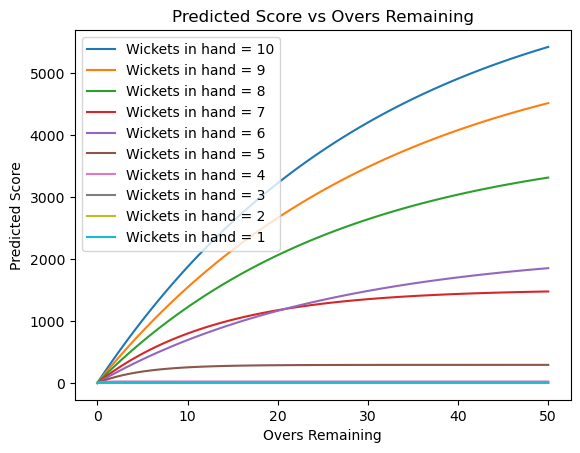

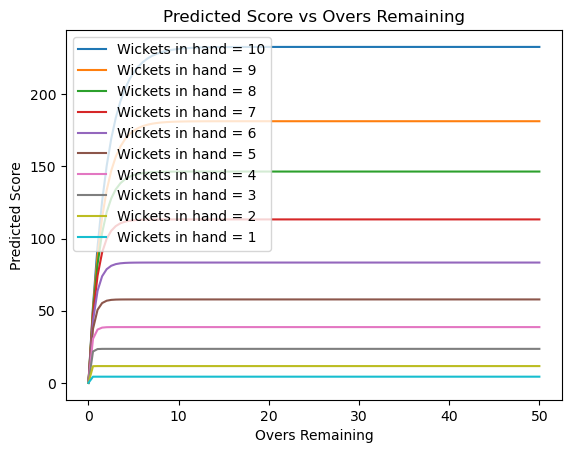

In [141]:
if __name__ == '__main__':
    args = {
        "data_path": "data\\04_cricket_1999to2011.csv",
        "model_path1": "models\\model1.pkl",  # ensure that the path exists
        "model_path2": "models\\model2.pkl",  # ensure that the path exists
        "plot_path1": "plots\\plot1.png",  # ensure that the path exists
        "plot_path2": "plots\\plot2.png"
    }
    main(args)
